Poniższa praca ma na celu scharakteryzowanie polskiego środowiska dziennikarzy sportowych (zajmujących się przede wszystkim piłką nożną) na postawie analizy ich kont twitterowych. Analizie poddano 51 dziennikarzy z 6 redakcji sportowych: przedstawicieli telewizji tradycyjnej (TVP Sport, Canal+), telewizji internetowej (ViaPlay) oraz formatów internetowych (Weszło, Kanał Sportowy, meczyki.pl). W ramach pracy zwrócono uwagę na popularność poszczególnych dziennikarzy a także powiązania między redakcjami.

Instalacja odpowiednich wersji bibliotek niezbędnych do generowania grafów

In [1]:
!pip install python-igraph==0.8.3
!apt install libcairo2-dev pkg-config python3-dev
!pip install python-igraph leidenalg cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 19.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev
  libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev
  libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils
The following NEW packages will be installed:
  

Import bibliotek

In [15]:
import tweepy
import time
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import igraph
from igraph import *
import cairocffi
import os

In [22]:
os.getcwd()

'/content'

Ustawienie logowania do API Twittera

In [3]:
key = '9j53bwQhtgeirnxlFwKxYiazr'
key_secret= 'Op3znNtnQI3D4wJtUWrfYjtXPrW7AcqiWlcqtRwdl7Cybg4s1m'

auth = tweepy.OAuthHandler(key, key_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Pobranie danych z pliku csv (imię i nazwisko, nick, redakcja)

In [ ]:
df = pd.read_csv('dataset.csv')

Ściągnięcie z pomocą API pozostałych wymaganych danych z Twittera (id profilu, liczba obserwowanych, liczba obserwujących, lista obserwowanych dziennikarzy z analizowanego zbioru)

In [ ]:
def add_twitter_data(df):
  def basic_info(nick):
    id = 0
    followers_count = 0
    following_count = 0
    user = api.get_user(nick)
    id = user.id
    followers_count = user.followers_count
    following_count = user.friends_count
    return id, followers_count, following_count
  (df['id'], df['followers_count'], df['following_count']) = np.vectorize(basic_info, otypes = [object, object, object])(df['nick'])

  col_list = df.id.values.tolist()

  def following_list(nick):
    following = []
    user = api.get_user(nick)
    for i, _id in enumerate(tweepy.Cursor(api.friends_ids, screen_name = nick).items()):
      if _id in col_list:
        following.append(_id)
    return following
  (df['following']) = np.vectorize(following_list, otypes = [object])(df['nick'])
  return df

  df_tw = add_twitter_data(df)

Zapis DataFrame'u na dysku komputera

In [ ]:
df_tw.to_csv('output.csv')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Struktura głównego DataFrame'a



In [4]:
df = pd.read_csv('output1.csv')
df.head()

,index,name,nick,media,id,followers_count,following_count,following1
0,0,Tomasz Ćwiąkała,cwiakala,CANAL,236586896,305783,1327,"[1057608774536609793, 1224740726, 759710584694..."
1,1,Andrzej Twarowski,TwaroTwaro,CANAL,2809623881,213982,228,"[365007636, 1128820086297583616, 1372073226, 1..."
2,2,Jakub Kręcidło,J_Krecidlo,CANAL,620925321,57485,1173,"[1128820086297583616, 1441449371350994944, 933..."
3,3,Bartosz Ignacik,BartekIgnacik,CANAL,1128820086297583616,19204,384,"[620925321, 1437825697, 933081649, 365007636, ..."
4,4,Edward Durda,DurdaEdward,CANAL,1441449371350994944,12334,71,"[2809623881, 43061493, 1183133300, 2691092842,..."


Wyznaczenie 10 najpopularniejszych (pod względem liczby obserwujących) dziennikarzy z badanego zbioru i przygotowanie na tej podstawie wykresu słupkowego

In [14]:
df_most_followers = df[['name', 'media', 'followers_count']].sort_values(by=['followers_count'], ascending=False).head(10)
df_most_followers

,name,media,followers_count
6,Mateusz Borek,KS,815790
7,Krzysztof Stanowski,KS,779933
8,Michał Pol,KS,648999
0,Tomasz Ćwiąkała,CANAL,305783
38,Wojciech Kowalczyk,WESZLO,228657
9,Tomasz Smokowski,KS,223609
1,Andrzej Twarowski,CANAL,213982
13,Mateusz Święcicki,MECZYKI,161832
14,Łukasz Wiśniowski,MECZYKI,152293
15,Tomasz Włodarczyk,MECZYKI,148869


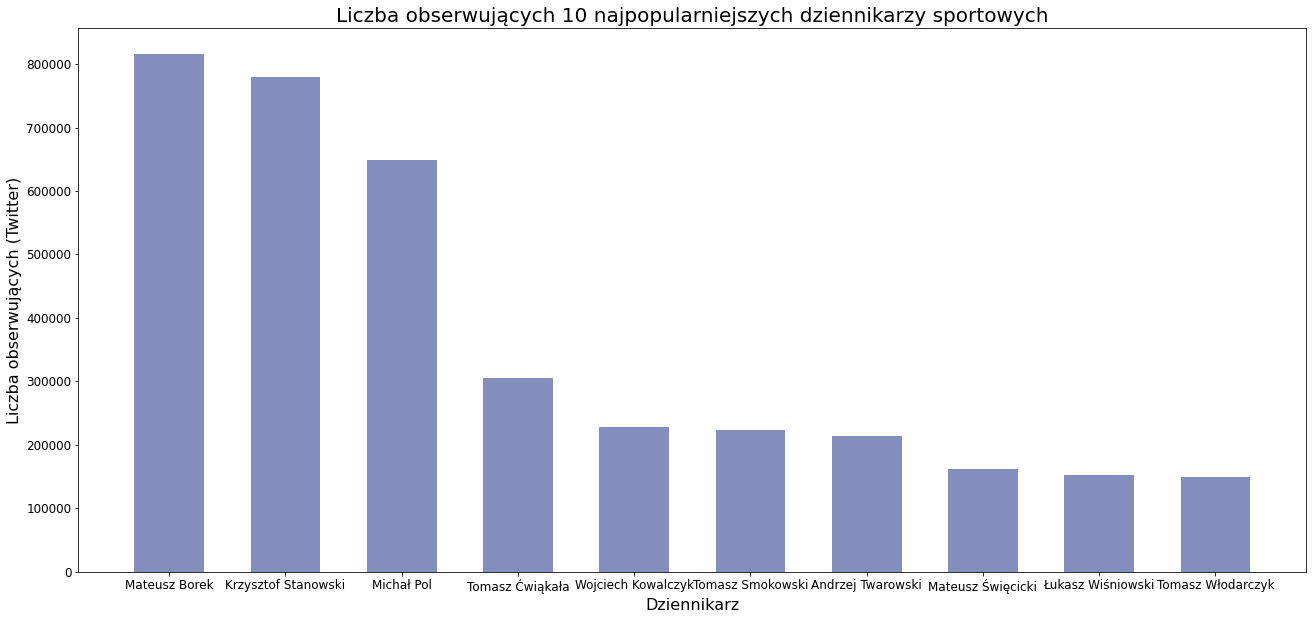

In [6]:
fig = plt.figure(figsize = (22, 10))
plt.rcParams['font.size'] = 12
plt.bar(df_most_followers['name'], df_most_followers['followers_count'], color ='#838EBE', width = 0.6)
plt.xlabel('Dziennikarz', fontsize=16)
plt.ylabel('Liczba obserwujących (Twitter)', fontsize=16)
plt.title('Liczba obserwujących 10 najpopularniejszych dziennikarzy sportowych', fontsize=20)
plt.show()

Analiza powyższych danych jasno wskazuje, że największą popularnością wśród dziennikarzy na Twitterze cieszą się ci reprezentujący Kanał Sportowy (1., 2., 3. oraz 6. miejsce rankingu zajmują założyciele wspomnianej redakcji). Kanał Sportowy to piewrszy projekt w polskim internecie, produkujący profesjonalne programy o tematyce sportowej który z czasem zaczął wykraczać poza ramy sportu i realizować programy na tematy społeczne. Jest to eksperyment, który - jak się okazuje - skutecznie wypełnił lukę między mediami internetowymi a tradycyjną telewizją, regularnie notując kilkumilionowe wyniki oglądalności.
Ponadto wśród najpopularniejszych dziennikarzy znajdują się przedstawiciele serwisu meczyki.pl - platformy w przeszłości słynącej z nielegalnych streamingów wydarzeń sportowych a aktualnie największego konkurenta Kanału Sportowego (funkcjonującej jednak w obecnej formie znacznie krócej, niż KS - odpowiednio rok i 3 lata).
Warto wspomnieć, że Kanał Sportowy oraz meczyki.pl zgromadziły na YouTub'ie, będącym głownym środkiem emisji programów) odpowiednio 945 tys. oraz 145 tys. subskrybentów.

Wyznaczenie średniej liczby obserwujących dziennikarzy z poszczególnych redakcji i przedstawienie ich na wykresie słupkowym

In [7]:
df_red_followers_count= df.groupby(['media'])['media'].count()
print(df_red_followers_count)

media
CANAL       6
KS          7
MECZYKI    14
TVP         5
VP          6
WESZLO     13
Name: media, dtype: int64


In [8]:
df_red_followers_sum= df[['media', 'followers_count']].groupby(by=['media'], as_index = False).sum([['followers_count']])
df_red_followers_sum['users_count'] = [6, 7, 14, 5, 6, 13]
df_red_followers_avg = df_red_followers_sum.assign(avg_followers=lambda x: round(x['followers_count'] / x['users_count'], 0))
print(df_red_followers_avg)

     media  followers_count  users_count  avg_followers
0    CANAL           609580            6       101597.0
1       KS          2717114            7       388159.0
2  MECZYKI           777795           14        55557.0
3      TVP           102716            5        20543.0
4       VP           126596            6        21099.0
5   WESZLO           758047           13        58311.0


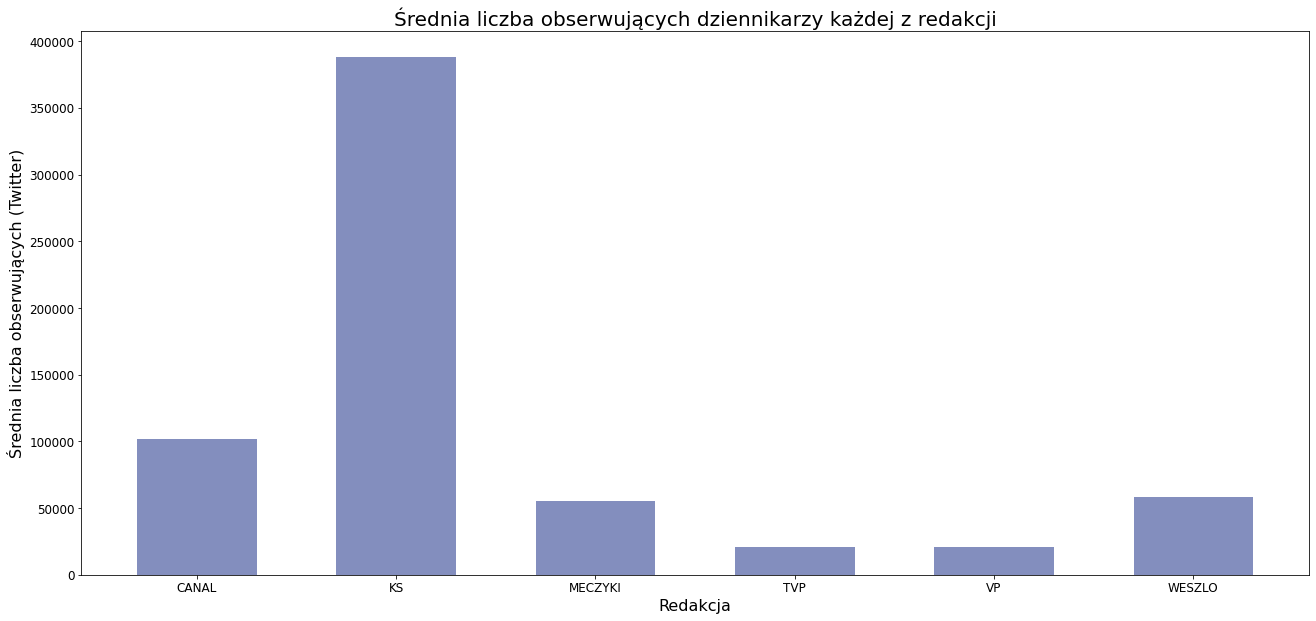

In [9]:
fig = plt.figure(figsize = (22, 10))
plt.rcParams['font.size'] = 12
plt.ticklabel_format(style='plain')
plt.bar(df_red_followers_avg['media'], df_red_followers_avg['avg_followers'], color ='#838EBE', width = 0.6)
plt.xlabel('Redakcja', fontsize=16)
plt.ylabel('Średnia liczba obserwujących (Twitter)', fontsize=16)
plt.title('Średnia liczba obserwujących dziennikarzy każdej z redakcji', fontsize=20)
plt.show()

Powyższy wykres pokazuje, że poza Kanałem Sportowym, deklasującym konkurencję z prawie 400-tysięczną średnią obserwujących, podobny poziom reprezentują meczyki.pl, WESZŁO oraz Canal+ (któemu średnią zauważalnie zawyża, uznawany powszechnie za najbardziej rzetelnego dziennikarza sportowego, Tomasz Ćwiąkała). Warto w tym miejscu wspomnieć, że WESZŁO jest redakcją powstałą pod przywódctwem Krzysztofa Stanowskiego (zarazem jednego z założycieli Kanału Sportowego), traktującą o sporcie w sposób humorystyczny. Warto zwrócić uwagę na niski wynik mediów tradycyjnych - TVP Sport oraz wchodzącej na rynek telewizji ViaPlay, których dziennikarze w znacznie mniejszym stopniu udzielają się w mediach społecznościowych.

Poprawa kolumny z obserwowanymi dziennikarzami do struktury umożliwiającej wygenerowanie datasetu krawędzi

In [10]:
def to_list(df):
  def to_list2(following1):
    following1 = following1.replace('[', '')
    following1 = following1.replace(']', '')
    following1 = following1.replace(' ', '')
    following_lst = following1.split(',')
    return following_lst
  df['following1'] = np.vectorize(to_list2, otypes = [object])(df['following1'])
  return df

df = to_list(df)

Przygotowanie datasetu węzłów

In [108]:
df_nl = df[['name', 'id', 'media', 'followers_count', 'following_count']]

Przygotowanie datasetu krawędzi

In [109]:
df_el = pd.DataFrame(columns = ['id1', 'id2', 'weight'])

for i, id1 in enumerate(list(df['id'])):
  following_list1 = df.loc[i,"following1"]
  for id2 in following_list1:
    df_el = df_el.append({'id1': int(id1), 'id2': int(id2)}, ignore_index=True)

df_el['weight'] = 1
df_el.head()

,id1,id2,weight
0,236586896.0,1.057609e+18,1
1,236586896.0,1.224741e+09,1
2,236586896.0,7.597106e+17,1
3,236586896.0,1.136300e+18,1
4,236586896.0,4.702754e+09,1


Zamiana id dziennikarzy na prostsze liczby (aliasy)

In [110]:
id_list = list(df['id'])
alias_list = [*range(0, len(df.index), 1)]

for i, j in zip(id_list, alias_list):
  df_el = df_el.replace(i, j)
df_el = df_el.round(0)

for i, j in zip(id_list, alias_list):
  df_nl = df_nl.replace(i, j)
df_nl = df_nl.round(0)

df_el['id1'] = df_el['id1'].astype(int)
df_el['id2'] = df_el['id2'].astype(int)

Eksport datasetów węzłów oraz krawędzi do plików csv

In [111]:
df_nl.to_csv('nl.csv')
df_el.to_csv('el.csv')

In [112]:
df_el['tuple'] = list(zip(df_el.id1, df_el.id2))

In [113]:
d = Graph()
d.add_vertices(51)
d.vs['nm'] = list(df_nl['name'])
d.vs['media'] = list(df_nl['media'])
d.vs['followers_count'] = list(df_nl['followers_count'])
d.vs['following_count'] = list(df_nl['following_count'])
d.add_edges(df_el['tuple'])
d.es['weight'] = list(df_el['weight'])

In [114]:
for index, row in df_nl.iterrows():
  print(row['name'])

Tomasz Ćwiąkała
Andrzej Twarowski
Jakub Kręcidło
Bartosz Ignacik
Edward Durda
Maciej Siemiątkowski
Mateusz Borek
Krzysztof Stanowski
Michał Pol
Tomasz Smokowski
Przemysław Rudzki
Robert Mazurek
Adam Sławiński
Mateusz Święcicki
Łukasz Wiśniowski
Tomasz Włodarczyk
Filip Kapica
Bożydar Iwanow
Piotr Dumanowski
Janusz Basałaj
Marcin Gazda
Samuel Szczygielski
Dominik Guziak
Sebastian Chabiniak
Maciej Łuczak
Jan Piekutowski
Maciej Pietrasik
Marek Szkolnikowski
Maciej Iwański
Wojciech Papuga
Sara Kalisz
Piotr Michałowski
Michał Zachodny
Rafał Wolski
Marcin Borzęcki
Piotr Domagała
Szymon Ratajczak
Dawid Szymczak
Wojciech Kowalczyk
Mateusz Rokuszewski
Jakub Olkiewicz
Leszek Milewski
Paweł Paczul
Jakub Białek
Wojciech Piela
Damian Smyk
Kamil Gapiński
Maciej Wąsowski
Szymon Janczyk
Jan Mazurek
Kamil Warzocha


In [115]:
print(summary(c))

IGRAPH U--- 51 1639 -- 
+ attr: color (v), followers_count (v), following_count (v), label (v), media (v), nm (v)
None


In [116]:
d.simplify(combine_edges='sum')

def subwt(attrs):
     if len(attrs) == 1:
         return attrs[0]
     assert len(attrs) == 2
     return attrs[0] - attrs[1]

d.to_undirected(combine_edges=subwt)

def combine_edges(graph):
    combe = graph.copy() # copies graph attributes, vertex attributes
    combe.delete_edges(None) # removes all edges
    for e in graph.es:
        src, targ = e.tuple
        if combe.are_connected(src, targ):
            ced = combe.es(_source=src, _target=targ)[0]
            ced['weight'] += e['weight']
        elif combe.are_connected(targ, src):
            ced = combe.es(_source=targ, _target=src)[0]
            ced['weight'] -= e['weight']
        else:
            combe.add_edge(src, targ, **e.attributes())
    return combe
    
d = combine_edges(d)

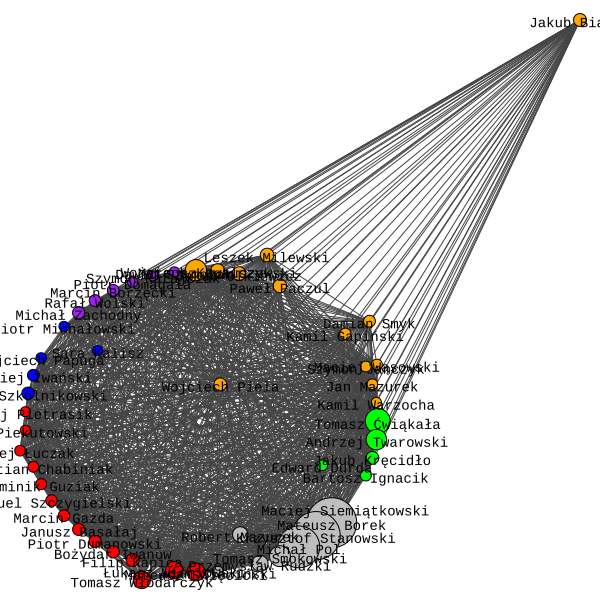

In [118]:
color_dict = {'KS': 'grey', 'WESZLO': 'orange', 'CANAL': 'green', 'TVP': 'blue', 'VP': 'purple', 'MECZYKI': 'red'}
d.vs['color'] = [color_dict[media] for media in d.vs['media']]
d.vs['label'] = d.vs['nm']
d.vs['size'] = rescale(d.vs['followers_count'], (10, 50))
plot(d)

In [75]:
ec = d.community_edge_betweenness()
ec = ec.as_clustering()
print(ec)

Clustering with 51 elements and 1 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50


In [64]:
l1 = ['Mark', 'Jan', 'Ola', 'Tom', 'Lot', 'Sky']
l2 = ['m', 'm', 'f', 'm', 'm', 'f']
l3 = [30, 21, 16, 13, 23, 10]
l4 = [0, 0, 0, 0, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5]
l5 = [1, 3, 4, 5, 3, 1, 5, 1, 4, 5, 3, 5, 3, 4]
l6 = [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2]
tup = list(zip(l4, l5))

In [91]:
gr = Graph(directed = False)
gr.add_vertices(6)
gr.vs['nm'] = l1
gr.vs['gen'] = l2
gr.vs['age'] = l3
gr.add_edges(tup)
gr.es['weight'] = l6

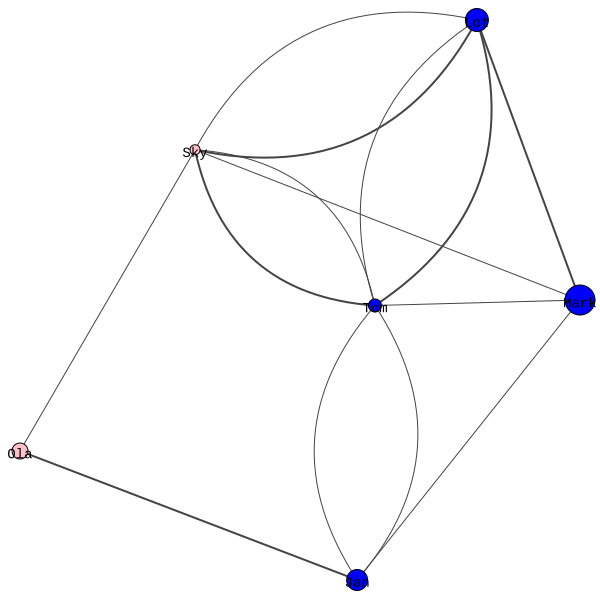

In [92]:
color_dict = {'m': 'blue', 'f': 'pink'}
gr.vs['color'] = [color_dict[gen] for gen in gr.vs['gen']]
gr.vs['label'] = gr.vs['nm']
gr.vs['size'] = gr.vs['age']
gr.es['width'] = gr.es['weight']
plot(gr, layout='kk')

In [101]:
gr.simplify(combine_edges='sum')

def subwt(attrs):
     if len(attrs) == 1:
         return attrs[0]
     assert len(attrs) == 2
     return attrs[0] - attrs[1]

gr.to_undirected(combine_edges=subwt)

def combine_edges(graph):
    combe = graph.copy() # copies graph attributes, vertex attributes
    combe.delete_edges(None) # removes all edges
    for e in graph.es:
        src, targ = e.tuple
        if combe.are_connected(src, targ):
            ced = combe.es(_source=src, _target=targ)[0]
            ced['weight'] += e['weight']
        elif combe.are_connected(targ, src):
            ced = combe.es(_source=targ, _target=src)[0]
            ced['weight'] -= e['weight']
        else:
            combe.add_edge(src, targ, **e.attributes())
    return combe

gr1 = combine_edges(gr)